# TF-IDF Analysis of NTSB Aviation Accident Narratives

**Objective**: Extract and analyze the most important terms and phrases from 67,126 aviation accident narrative descriptions using TF-IDF (Term Frequency-Inverse Document Frequency) vectorization.

**Dataset**: NTSB Aviation Accident Database (1977-2025, 48 years)

**Methods**:
- TF-IDF vectorization for unigrams, bigrams, and trigrams
- Top 100 most important terms across entire corpus
- Per-decade TF-IDF to track language evolution
- Word clouds, bar charts, and heatmaps for visualization

**Author**: Claude Code (Anthropic)

**Date**: 2025-11-08

## 1. Setup and Data Loading

In [1]:
# Standard library imports
import re
import warnings
from typing import List, Tuple

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP imports
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('Set2')

# Set random seed for reproducibility
np.random.seed(42)

print('✅ Libraries imported successfully')

✅ Libraries imported successfully


In [2]:
# Load narrative dataset
df = pd.read_parquet('../../data/narratives_dataset.parquet')

print(f'Dataset: {len(df):,} narrative records')
print(f'Date range: {df["ev_year"].min()} - {df["ev_year"].max()}')
print(f'\nNarrative completeness:')
print(f'  narr_accp (accident): {df["narr_accp"].notna().sum():,} ({df["narr_accp"].notna().mean()*100:.1f}%)')
print(f'  narr_cause (probable cause): {df["narr_cause"].notna().sum():,} ({df["narr_cause"].notna().mean()*100:.1f}%)')
print(f'\nFatal accidents: {(df["inj_tot_f"] > 0).sum():,} ({(df["inj_tot_f"] > 0).mean()*100:.1f}%)')

df.head()

Dataset: 67,126 narrative records
Date range: 1977 - 2025

Narrative completeness:
  narr_accp (accident): 53,163 (79.2%)
  narr_cause (probable cause): 63,605 (94.8%)

Fatal accidents: 13,090 (19.5%)


,ev_id,narr_accp,narr_cause,ev_year,ev_date,ev_highest_injury,inj_tot_f,inj_tot_s,ev_state,acft_make,acft_model
0,20080204X00131,The pilot reported while making an approach to...,The pilot's misjudged landing flare and improp...,2008,2008-01-08,NONE,0,0,CA,Robinson,R-22
1,20080204X00132,"On January 16, 2008, about 1850 universal coor...",None,2008,2008-01-16,None,0,0,None,Bell,212
2,20080129X00119,"HISTORY OF FLIGHT\r\n\r\nOn January 16, 2008, ...",The pilot's loss of control due to spatial dis...,2008,2008-01-17,FATL,1,0,OK,AERO COMMANDER,500B
3,20080117X00065,import,None,2008,2008-01-17,MINR,0,0,None,Boeing,777-236ER
4,20080117X00067,"HISTORY OF FLIGHT\r\n\r\nOn January 14, 2008, ...",The pilot's spatial disorientation and loss of...,2008,2008-01-14,FATL,1,0,HI,Hawker Beechcraft Corporation,1900C


## 2. Text Preprocessing

In [3]:
def preprocess_text(text: str) -> str:
    """
    Clean and normalize narrative text.
    
    Args:
        text: Raw narrative text
        
    Returns:
        Cleaned and normalized text
    """
    if pd.isna(text):
        return ''
    
    # Convert to string and lowercase
    text = str(text).lower()
    
    # Remove URLs and emails
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove special characters (keep spaces, hyphens, and apostrophes)
    text = re.sub(r"[^a-z0-9\s'-]", ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Combine narratives and preprocess
df['full_narrative'] = (df['narr_accp'].fillna('') + ' ' + df['narr_cause'].fillna('')).str.strip()
df['clean_narrative'] = df['full_narrative'].apply(preprocess_text)

# Remove empty narratives
df = df[df['clean_narrative'].str.len() > 0].reset_index(drop=True)

print(f'✅ Preprocessed {len(df):,} narratives')
print(f'Average narrative length: {df["clean_narrative"].str.split().str.len().mean():.0f} words')
print(f'Median narrative length: {df["clean_narrative"].str.split().str.len().median():.0f} words')

# Display example
print('\nExample preprocessed narrative:')
print(f'Original: {df["full_narrative"].iloc[0][:200]}...')
print(f'Cleaned: {df["clean_narrative"].iloc[0][:200]}...')

✅ Preprocessed 67,126 narratives


Average narrative length: 534 words


Median narrative length: 256 words

Example preprocessed narrative:
Original: The pilot reported while making an approach to a hover about 15 feet above ground level (agl), he applied power to stop the decent rate and the helicopter began to yaw to the right.  Despite the pilot...
Cleaned: the pilot reported while making an approach to a hover about 15 feet above ground level agl he applied power to stop the decent rate and the helicopter began to yaw to the right despite the pilot addi...


## 3. TF-IDF Vectorization (Unigrams, Bigrams, Trigrams)

In [4]:
# Configure TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 3),  # Unigrams, bigrams, trigrams
    min_df=10,  # Minimum document frequency (appears in at least 10 documents)
    max_df=0.7,  # Maximum document frequency (ignore terms in >70% of documents)
    stop_words='english',
    sublinear_tf=True,  # Use log scaling for term frequency
    norm='l2'  # L2 normalization
)

# Fit and transform
print('🔄 Computing TF-IDF matrix...')
tfidf_matrix = vectorizer.fit_transform(df['clean_narrative'])
feature_names = vectorizer.get_feature_names_out()

print(f'✅ TF-IDF matrix shape: {tfidf_matrix.shape}')
print(f'   Documents: {tfidf_matrix.shape[0]:,}')
print(f'   Features: {tfidf_matrix.shape[1]:,}')
print(f'   Sparsity: {(1 - tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])) * 100:.2f}%')

🔄 Computing TF-IDF matrix...


✅ TF-IDF matrix shape: (67126, 5000)
   Documents: 67,126
   Features: 5,000
   Sparsity: 95.77%


## 4. Top 100 Most Important Terms

In [5]:
# Compute aggregate TF-IDF scores
tfidf_scores = np.asarray(tfidf_matrix.sum(axis=0)).ravel()

# Get top 100 terms
top_indices = tfidf_scores.argsort()[-100:][::-1]
top_terms = [(feature_names[i], tfidf_scores[i]) for i in top_indices]

# Create DataFrame
top_terms_df = pd.DataFrame(top_terms, columns=['term', 'tfidf_score'])
top_terms_df['rank'] = range(1, 101)

# Categorize n-grams
top_terms_df['ngram_type'] = top_terms_df['term'].apply(
    lambda x: 'unigram' if len(x.split()) == 1 else ('bigram' if len(x.split()) == 2 else 'trigram')
)

print('Top 30 Most Important Terms:\n')
print(top_terms_df.head(30).to_string(index=False))

print(f'\nN-gram distribution in top 100:')
print(top_terms_df['ngram_type'].value_counts())

Top 30 Most Important Terms:

          term  tfidf_score  rank ngram_type
      airplane  2835.735559     1    unigram
       landing  2366.891898     2    unigram
        engine  1956.049600     3    unigram
      accident  1934.737172     4    unigram
        runway  1891.916420     5    unigram
       failure  1777.357515     6    unigram
      reported  1636.731530     7    unigram
       control  1624.055066     8    unigram
          time  1597.946903     9    unigram
          fuel  1552.514554    10    unigram
          left  1519.385062    11    unigram
         power  1488.100132    12    unigram
       airport  1475.581633    13    unigram
      aircraft  1447.174208    14    unigram
         right  1434.172643    15    unigram
      maintain  1316.563286    16    unigram
    conditions  1268.266348    17    unigram
          loss  1245.070099    18    unigram
        stated  1231.157272    19    unigram
        damage  1230.552124    20    unigram
        ground  1212.5201

## 5. Visualizations

### 5.1 Word Cloud (Top 50 Terms)

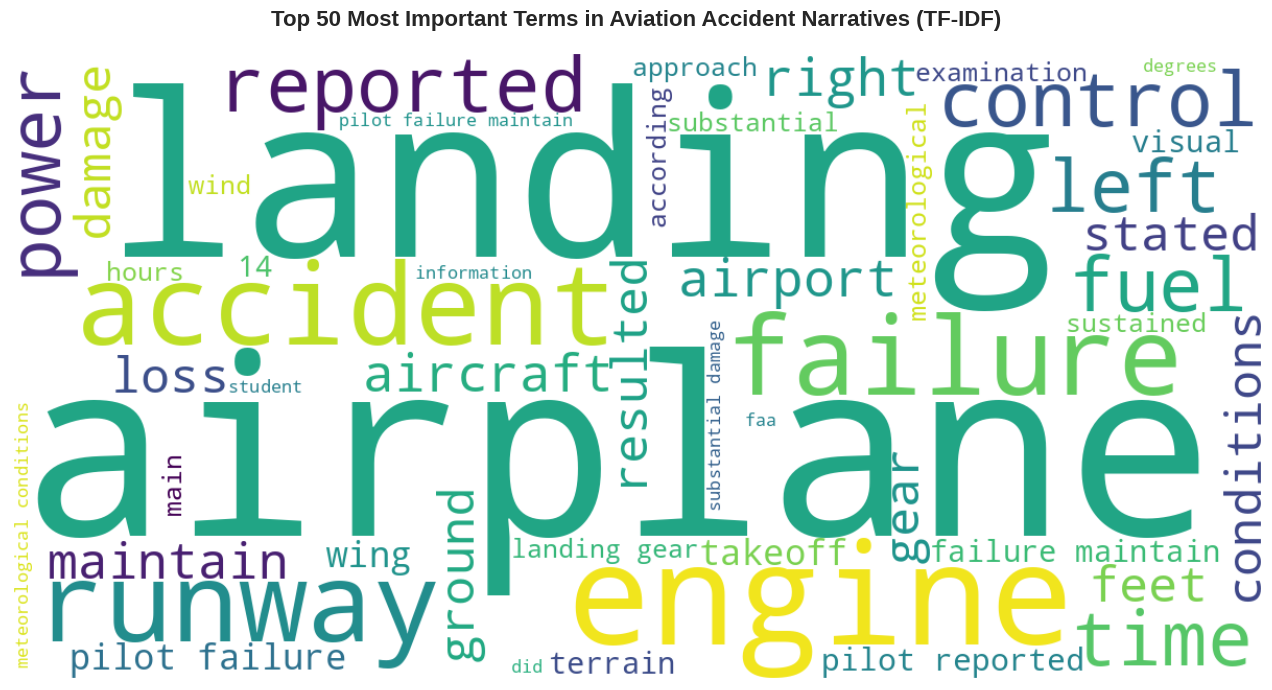

✅ Word cloud saved: figures/tfidf_wordcloud_top50.png


In [6]:
# Create word cloud
wordcloud_dict = {term: score for term, score in top_terms[:50]}

wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color='white',
    colormap='viridis',
    relative_scaling=0.5,
    min_font_size=10
).generate_from_frequencies(wordcloud_dict)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 50 Most Important Terms in Aviation Accident Narratives (TF-IDF)', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('figures/tfidf_wordcloud_top50.png', dpi=150, bbox_inches='tight')
plt.show()

print('✅ Word cloud saved: figures/tfidf_wordcloud_top50.png')

### 5.2 Bar Chart (Top 30 Terms)

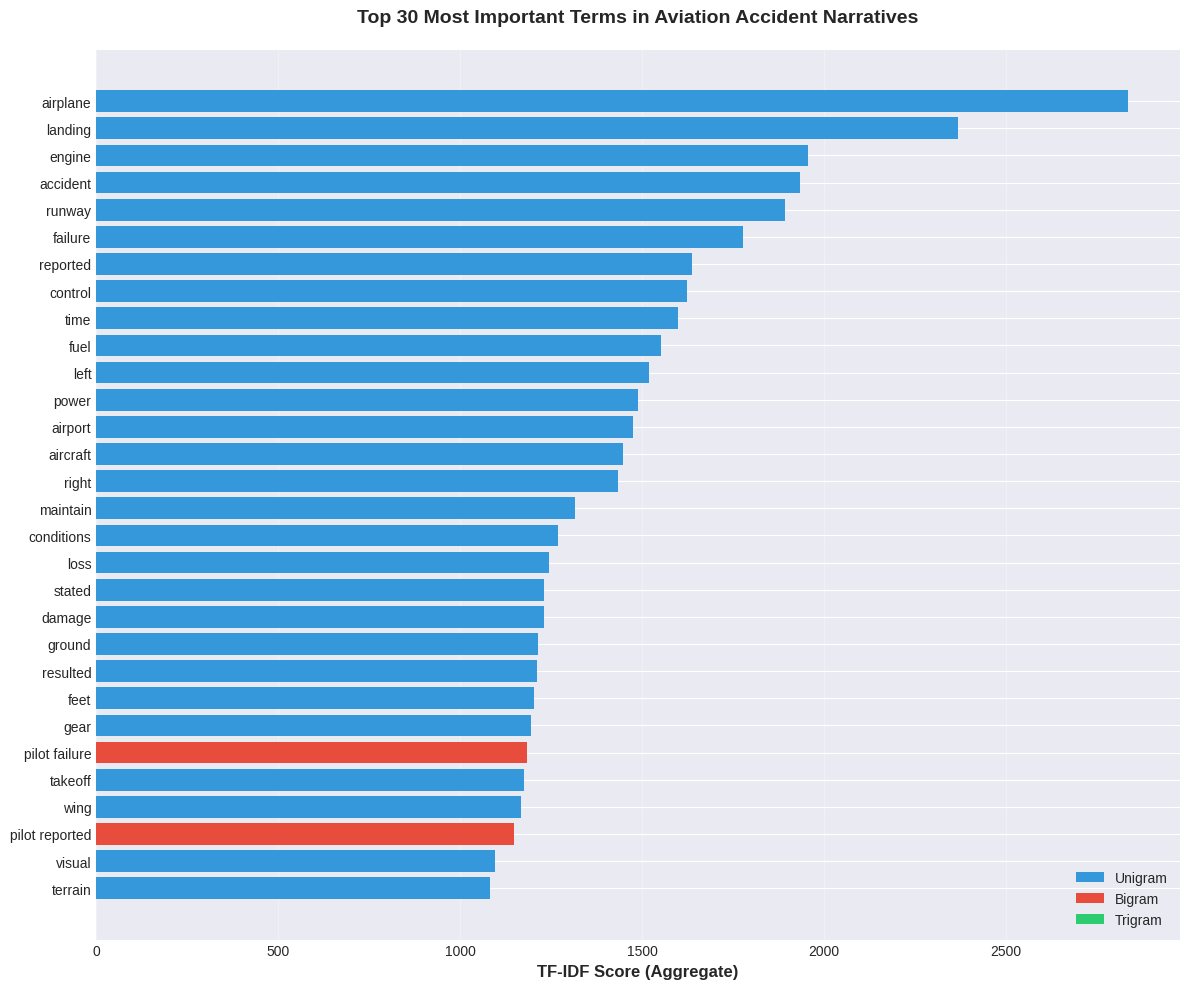

✅ Bar chart saved: figures/tfidf_barchart_top30.png


In [7]:
# Create bar chart for top 30 terms
fig, ax = plt.subplots(figsize=(12, 10))

colors = top_terms_df.head(30)['ngram_type'].map({
    'unigram': '#3498db',
    'bigram': '#e74c3c',
    'trigram': '#2ecc71'
})

ax.barh(range(30), top_terms_df.head(30)['tfidf_score'], color=colors)
ax.set_yticks(range(30))
ax.set_yticklabels(top_terms_df.head(30)['term'], fontsize=10)
ax.set_xlabel('TF-IDF Score (Aggregate)', fontsize=12, fontweight='bold')
ax.set_title('Top 30 Most Important Terms in Aviation Accident Narratives', 
             fontsize=14, fontweight='bold', pad=20)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#3498db', label='Unigram'),
    Patch(facecolor='#e74c3c', label='Bigram'),
    Patch(facecolor='#2ecc71', label='Trigram')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.savefig('figures/tfidf_barchart_top30.png', dpi=150, bbox_inches='tight')
plt.show()

print('✅ Bar chart saved: figures/tfidf_barchart_top30.png')

## 6. Per-Decade TF-IDF Analysis

In [8]:
# Add decade column
df['decade'] = (df['ev_year'] // 10) * 10

# Get decades with sufficient data
decade_counts = df['decade'].value_counts().sort_index()
valid_decades = decade_counts[decade_counts >= 100].index.tolist()

print(f'Analyzing {len(valid_decades)} decades with sufficient data (≥100 narratives):\n')
print(decade_counts[decade_counts >= 100].to_string())

Analyzing 5 decades with sufficient data (≥100 narratives):

decade
1980     2867
1990    22116
2000    18609
2010    16667
2020     6864


In [9]:
# Compute per-decade TF-IDF
decade_tfidf = {}

for decade in valid_decades:
    decade_texts = df[df['decade'] == decade]['clean_narrative'].tolist()
    
    vectorizer_decade = TfidfVectorizer(
        max_features=1000,
        ngram_range=(1, 2),  # Unigrams and bigrams only for decades
        min_df=5,
        max_df=0.7,
        stop_words='english',
        sublinear_tf=True
    )
    
    tfidf_decade = vectorizer_decade.fit_transform(decade_texts)
    scores_decade = np.asarray(tfidf_decade.sum(axis=0)).ravel()
    features_decade = vectorizer_decade.get_feature_names_out()
    
    # Get top 20 terms for this decade
    top_indices_decade = scores_decade.argsort()[-20:][::-1]
    top_terms_decade = [(features_decade[i], scores_decade[i]) for i in top_indices_decade]
    
    decade_tfidf[decade] = top_terms_decade
    
    print(f'\n{decade}s (n={len(decade_texts):,} narratives):')
    for i, (term, score) in enumerate(top_terms_decade[:10], 1):
        print(f'  {i:2d}. {term:25s} {score:8.1f}')

print('\n✅ Per-decade TF-IDF analysis complete')


1980s (n=2,867 narratives):
   1. failure                      146.2
   2. landing                      105.9
   3. maintain                      90.9
   4. aircraft                      89.3
   5. fuel                          88.8
   6. contributing                  88.0
   7. control                       86.5
   8. accident                      84.1
   9. improper                      82.4
  10. resulted                      79.7



1990s (n=22,116 narratives):
   1. flight                      1270.2
   2. airplane                    1161.7
   3. landing                     1098.3
   4. failure                     1048.1
   5. accident                     963.7
   6. engine                       943.8
   7. aircraft                     897.5
   8. runway                       841.5
   9. fuel                         840.1
  10. time                         797.4



2000s (n=18,609 narratives):
   1. runway                       955.8
   2. engine                       897.7
   3. left                         773.1
   4. right                        742.1
   5. feet                         716.9
   6. power                        682.1
   7. stated                       658.9
   8. aircraft                     656.3
   9. fuel                         653.6
  10. control                      646.9



2010s (n=16,667 narratives):
   1. landing                      903.2
   2. reported                     794.4
   3. runway                       781.7
   4. engine                       769.2
   5. left                         686.2
   6. right                        650.8
   7. pilot reported               624.7
   8. time                         622.9
   9. airport                      611.9
  10. information                  594.3



2020s (n=6,864 narratives):
   1. landing                      488.3
   2. airplane                     447.6
   3. failure                      405.9
   4. pilot failure                397.9
   5. resulted                     379.9
   6. control                      374.1
   7. maintain                     361.9
   8. failure maintain             358.0
   9. flight                       320.2
  10. engine                       292.0

✅ Per-decade TF-IDF analysis complete


### 6.1 Heatmap: Top Terms Across Decades

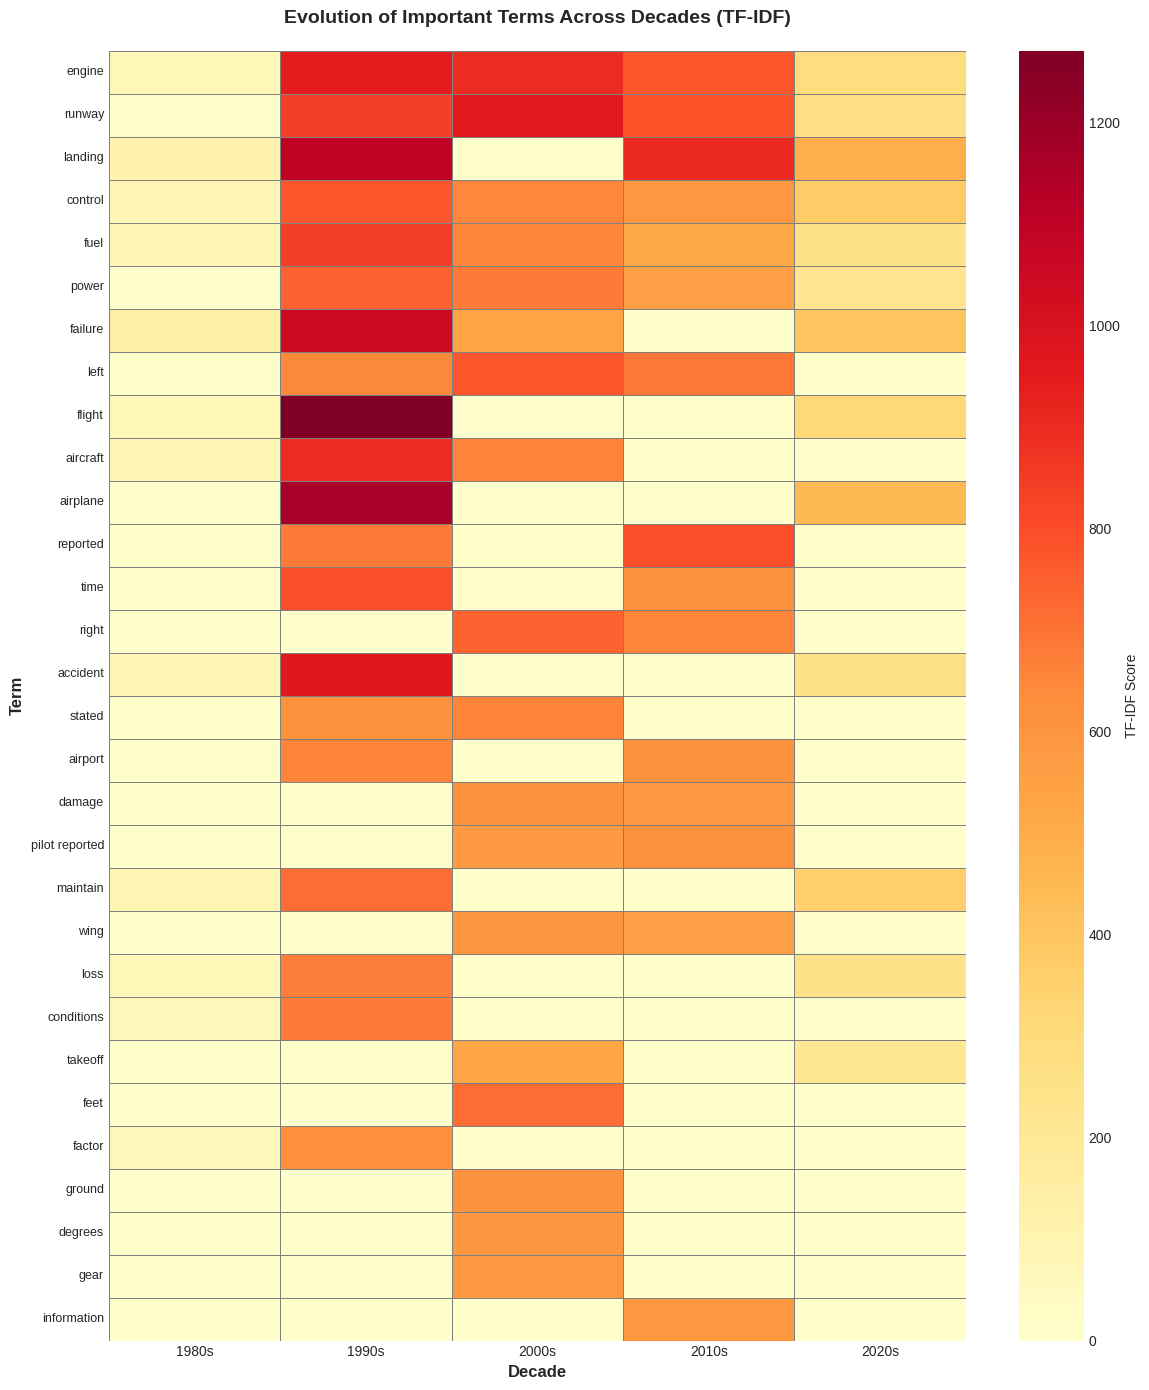

✅ Heatmap saved: figures/tfidf_heatmap_decades.png


In [10]:
# Create heatmap data
# Get unique terms across all decades (top 30 most frequent)
all_decade_terms = {}
for decade, terms in decade_tfidf.items():
    for term, score in terms:
        if term not in all_decade_terms:
            all_decade_terms[term] = 0
        all_decade_terms[term] += score

# Get top 30 terms overall
top_overall_terms = sorted(all_decade_terms.items(), key=lambda x: x[1], reverse=True)[:30]
selected_terms = [term for term, _ in top_overall_terms]

# Build heatmap matrix
heatmap_data = []
for term in selected_terms:
    row = []
    for decade in sorted(valid_decades):
        decade_dict = dict(decade_tfidf[decade])
        row.append(decade_dict.get(term, 0))
    heatmap_data.append(row)

heatmap_df = pd.DataFrame(
    heatmap_data,
    index=selected_terms,
    columns=[f"{int(d)}s" for d in sorted(valid_decades)]
)

# Plot heatmap
plt.figure(figsize=(12, 14))
sns.heatmap(
    heatmap_df,
    cmap='YlOrRd',
    cbar_kws={'label': 'TF-IDF Score'},
    linewidths=0.5,
    linecolor='gray',
    fmt='.0f'
)
plt.title('Evolution of Important Terms Across Decades (TF-IDF)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Decade', fontsize=12, fontweight='bold')
plt.ylabel('Term', fontsize=12, fontweight='bold')
plt.xticks(rotation=0)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.savefig('figures/tfidf_heatmap_decades.png', dpi=150, bbox_inches='tight')
plt.show()

print('✅ Heatmap saved: figures/tfidf_heatmap_decades.png')

## 7. TF-IDF by Fatal vs Non-Fatal Accidents

In [11]:
# Add fatal outcome flag
df['fatal_outcome'] = df['inj_tot_f'] > 0

# Compute TF-IDF for fatal and non-fatal separately
fatal_texts = df[df['fatal_outcome']]['clean_narrative'].tolist()
nonfatal_texts = df[~df['fatal_outcome']]['clean_narrative'].tolist()

print(f'Fatal narratives: {len(fatal_texts):,}')
print(f'Non-fatal narratives: {len(nonfatal_texts):,}')

# Fatal TF-IDF
vectorizer_fatal = TfidfVectorizer(
    max_features=1000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.7,
    stop_words='english',
    sublinear_tf=True
)
tfidf_fatal = vectorizer_fatal.fit_transform(fatal_texts)
scores_fatal = np.asarray(tfidf_fatal.sum(axis=0)).ravel()
features_fatal = vectorizer_fatal.get_feature_names_out()
top_fatal = sorted(zip(features_fatal, scores_fatal), key=lambda x: x[1], reverse=True)[:20]

# Non-fatal TF-IDF
vectorizer_nonfatal = TfidfVectorizer(
    max_features=1000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.7,
    stop_words='english',
    sublinear_tf=True
)
tfidf_nonfatal = vectorizer_nonfatal.fit_transform(nonfatal_texts)
scores_nonfatal = np.asarray(tfidf_nonfatal.sum(axis=0)).ravel()
features_nonfatal = vectorizer_nonfatal.get_feature_names_out()
top_nonfatal = sorted(zip(features_nonfatal, scores_nonfatal), key=lambda x: x[1], reverse=True)[:20]

print('\nTop 20 Terms in FATAL Accidents:')
for i, (term, score) in enumerate(top_fatal, 1):
    print(f'  {i:2d}. {term:25s} {score:8.1f}')

print('\nTop 20 Terms in NON-FATAL Accidents:')
for i, (term, score) in enumerate(top_nonfatal, 1):
    print(f'  {i:2d}. {term:25s} {score:8.1f}')

Fatal narratives: 13,090
Non-fatal narratives: 54,036



Top 20 Terms in FATAL Accidents:
   1. information                  631.7
   2. aircraft                     547.0
   3. failure                      506.5
   4. airport                      493.7
   5. feet                         489.1
   6. left                         468.4
   7. fuel                         466.5
   8. hours                        457.0
   9. wreckage                     455.5
  10. government                   454.6
  11. impact                       451.1
  12. right                        446.1
  13. wing                         438.8
  14. reported                     435.1
  15. degrees                      429.0
  16. terrain                      424.1
  17. faa                          412.2
  18. ground                       409.7
  19. altitude                     406.8
  20. investigation                406.6

Top 20 Terms in NON-FATAL Accidents:
   1. airplane                    3461.6
   2. landing                     2990.2
   3. flight              

### 7.1 Comparison Visualization

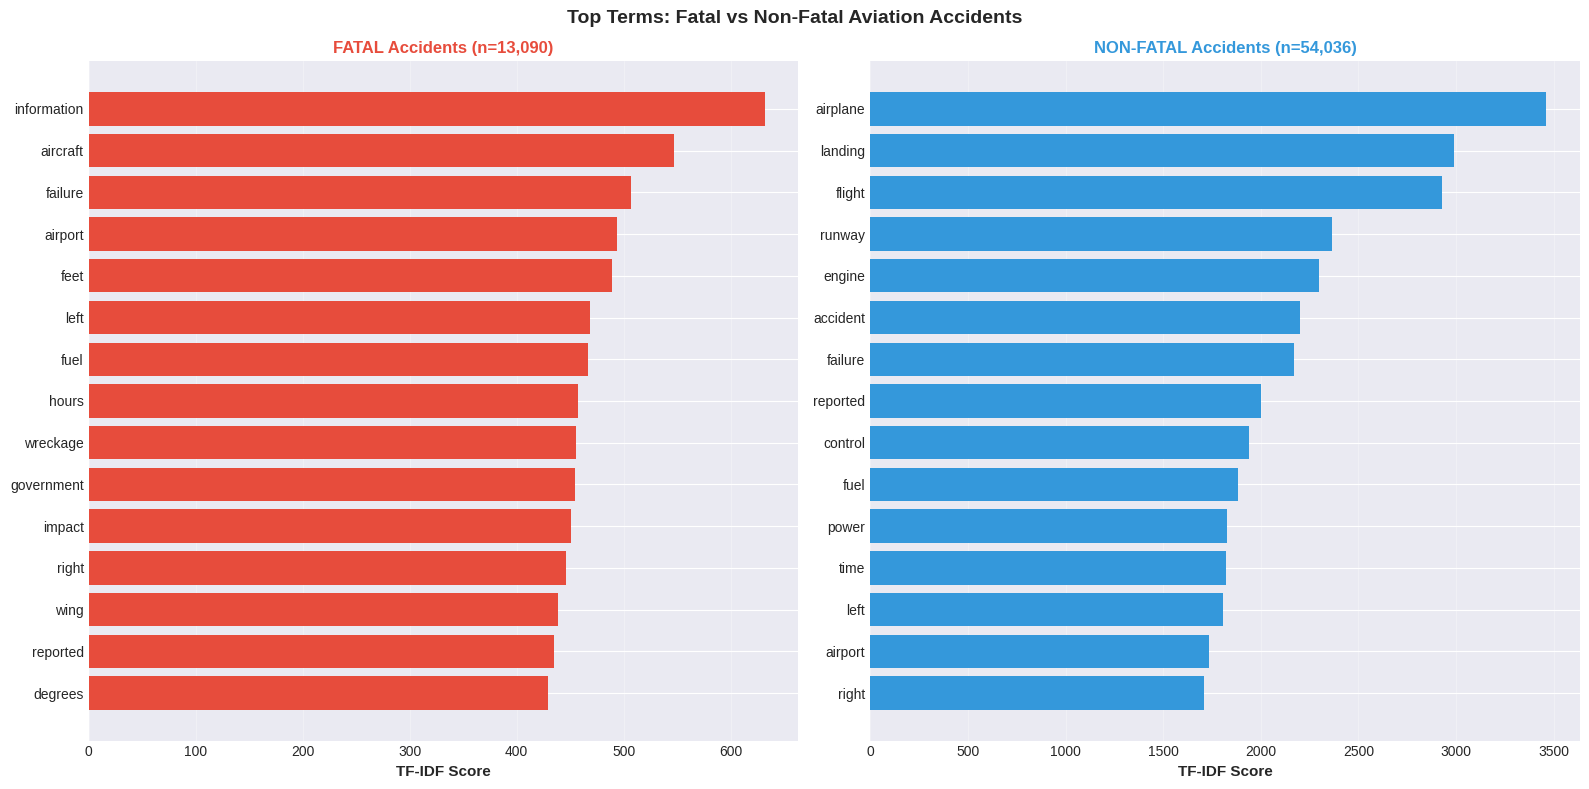

✅ Comparison chart saved: figures/tfidf_fatal_vs_nonfatal.png


In [12]:
# Create side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Fatal accidents
fatal_df = pd.DataFrame(top_fatal[:15], columns=['term', 'score'])
axes[0].barh(range(15), fatal_df['score'], color='#e74c3c')
axes[0].set_yticks(range(15))
axes[0].set_yticklabels(fatal_df['term'], fontsize=10)
axes[0].set_xlabel('TF-IDF Score', fontsize=11, fontweight='bold')
axes[0].set_title(f'FATAL Accidents (n={len(fatal_texts):,})', 
                  fontsize=12, fontweight='bold', color='#e74c3c')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Non-fatal accidents
nonfatal_df = pd.DataFrame(top_nonfatal[:15], columns=['term', 'score'])
axes[1].barh(range(15), nonfatal_df['score'], color='#3498db')
axes[1].set_yticks(range(15))
axes[1].set_yticklabels(nonfatal_df['term'], fontsize=10)
axes[1].set_xlabel('TF-IDF Score', fontsize=11, fontweight='bold')
axes[1].set_title(f'NON-FATAL Accidents (n={len(nonfatal_texts):,})', 
                  fontsize=12, fontweight='bold', color='#3498db')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

fig.suptitle('Top Terms: Fatal vs Non-Fatal Aviation Accidents', 
             fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('figures/tfidf_fatal_vs_nonfatal.png', dpi=150, bbox_inches='tight')
plt.show()

print('✅ Comparison chart saved: figures/tfidf_fatal_vs_nonfatal.png')

## 8. Summary Statistics

In [13]:
print('='*70)
print('TF-IDF ANALYSIS SUMMARY')
print('='*70)

print(f'\n📊 Dataset Statistics:')
print(f'   Total narratives analyzed: {len(df):,}')
print(f'   Date range: {df["ev_year"].min()} - {df["ev_year"].max()} ({df["ev_year"].max() - df["ev_year"].min() + 1} years)')
print(f'   Average narrative length: {df["clean_narrative"].str.split().str.len().mean():.0f} words')
print(f'   Fatal accidents: {(df["fatal_outcome"]).sum():,} ({(df["fatal_outcome"]).mean()*100:.1f}%)')

print(f'\n🔍 TF-IDF Vectorization:')
print(f'   Total features extracted: {len(feature_names):,}')
print(f'   N-gram range: unigrams, bigrams, trigrams')
print(f'   Matrix sparsity: {(1 - tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])) * 100:.2f}%')

print(f'\n📈 Top 10 Most Important Terms (Overall):')
for i, (term, score) in enumerate(top_terms[:10], 1):
    print(f'   {i:2d}. {term:30s} {score:10.1f}')

print(f'\n📅 Decades Analyzed: {len(valid_decades)}')
for decade in sorted(valid_decades):
    count = decade_counts[decade]
    print(f'   {decade}s: {count:,} narratives')

print(f'\n💾 Visualizations Created:')
print(f'   1. Word cloud (top 50 terms)')
print(f'   2. Bar chart (top 30 terms)')
print(f'   3. Heatmap (terms across decades)')
print(f'   4. Fatal vs Non-fatal comparison')

print('\n✅ TF-IDF Analysis Complete!')
print('='*70)

TF-IDF ANALYSIS SUMMARY

📊 Dataset Statistics:
   Total narratives analyzed: 67,126
   Date range: 1977 - 2025 (49 years)


   Average narrative length: 534 words
   Fatal accidents: 13,090 (19.5%)

🔍 TF-IDF Vectorization:
   Total features extracted: 5,000
   N-gram range: unigrams, bigrams, trigrams
   Matrix sparsity: 95.77%

📈 Top 10 Most Important Terms (Overall):
    1. airplane                           2835.7
    2. landing                            2366.9
    3. engine                             1956.0
    4. accident                           1934.7
    5. runway                             1891.9
    6. failure                            1777.4
    7. reported                           1636.7
    8. control                            1624.1
    9. time                               1597.9
   10. fuel                               1552.5

📅 Decades Analyzed: 5
   1980s: 2,867 narratives
   1990s: 22,116 narratives
   2000s: 18,609 narratives
   2010s: 16,667 narratives
   2020s: 6,864 narratives

💾 Visualizations Created:
   1. Word cloud (top 50 terms)
   2. Bar chart (top 30 terms)
   3. Heatm

## 9. Export Results

In [14]:
# Export top 100 terms to CSV
top_terms_df.to_csv('../../data/tfidf_top100_terms.csv', index=False)
print('✅ Exported top 100 terms to: data/tfidf_top100_terms.csv')

# Export decade analysis
decade_results = []
for decade in sorted(valid_decades):
    for rank, (term, score) in enumerate(decade_tfidf[decade], 1):
        decade_results.append({
            'decade': f'{decade}s',
            'rank': rank,
            'term': term,
            'tfidf_score': score
        })

decade_df = pd.DataFrame(decade_results)
decade_df.to_csv('../../data/tfidf_by_decade.csv', index=False)
print('✅ Exported decade analysis to: data/tfidf_by_decade.csv')

print('\n🎉 All TF-IDF analysis results saved successfully!')

✅ Exported top 100 terms to: data/tfidf_top100_terms.csv
✅ Exported decade analysis to: data/tfidf_by_decade.csv

🎉 All TF-IDF analysis results saved successfully!
